# Testing removing velocity artifacts with A11 winter data

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import pickle

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    18:26:13 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    18:26:13 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    18:26:13 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
with open('../chirp_processing/A11_22S.pickle', 'rb') as handle:
    s22 = pickle.load(handle)

with open('../chirp_processing/A11_22W.pickle', 'rb') as handle:
    winter = pickle.load(handle)

In [11]:
def strain_metrics(ds, win_cor, step, lag, noise_floor):
    # This function, given a window, and step, gives a total percentage of data that has high coherence
    b1 = ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    dz, co, phi = xa.generate_range_diff(b1,b2,win_cor,step,None,0,0.95)
    dz=dz.assign(coherence=(['time','profile_range'],co))
    dz_new = dz.where(abs(dz.coherence) > 0.95).drop_duplicates('time')

    vv = dz_new.range_diff / dz_new.time_diff * 31536000
    vv_adjust = vv - vv.where(vv.profile_range<100).where(vv.profile_range > 50).mean(dim='profile_range')
    vv_err = dz_new.err / dz_new.time_diff * 31536000
    vv_mean_err = (vv_err.where(vv.profile_range<100).where(vv.profile_range > 50)**2).sum(dim='profile_range')/len(vv_err.profile_range.where(vv.profile_range<100,drop=True).where(vv.profile_range > 50,drop=True))
    vv_adjust_err = np.sqrt(vv_err**2 + vv_mean_err**2)

    fit=vv.where(vv.profile_range <=noise_floor).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv.where(vv.profile_range <=noise_floor)-vv.where(vv.profile_range <=noise_floor).mean())**2).sum(dim='profile_range')
    
    slope = fit.polyfit_coefficients.sel(degree=1)*vv.profile_range+fit.polyfit_coefficients.sel(degree=0)
    residual = vv-slope
    residual = residual.where(residual.profile_range <=noise_floor,drop=True)
    slope_errs = np.sqrt((1/(len(residual.profile_range)-2))*(((residual**2).sum(dim='profile_range'))/((residual.profile_range - residual.profile_range.mean())**2).sum()))

    int_err = slope_errs*np.sqrt(((vv.profile_range)**2).sum()/len(vv.profile_range))
    ds = vv.to_dataset(name='vv')
    ds['err'] = vv_err
    ds['slope']= fit.polyfit_coefficients.sel(degree=1)
    ds['intercept']=fit.polyfit_coefficients.sel(degree=0)
    ds['fit'] = slope
    ds['slope_err'] = slope_errs
    ds['int_err'] = int_err
    ds['vv_adjust'] = vv_adjust
    ds['vv_adjust_err'] = vv_adjust_err
    ds['doy_decimal'] =  ds.time.dt.dayofyear + (ds.time.dt.hour / 24) + (ds.time.dt.minute / 1440) + (ds.time.dt.second / 86400)
    return ds

def plot_fits(ds_15,ds_hour,xlims=False):
    fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
    axs[0].errorbar(ds_15.doy_decimal,ds_15.slope,yerr=ds_15.slope_err,marker='.',ecolor='k',label = '15 minute')
    axs[0].errorbar(ds_hour.doy_decimal,ds_hour.slope,yerr=ds_hour.slope_err,marker='.',ecolor='r',label = '1 hour')
    axs[0].legend()
    if xlims:
        axs[0].set_xlim(xlims)
    axs[0].set_ylabel('Strain rate [y$^{-1}$]')
    axs[0].set_title('Strain rate estimates')
    
    axs[1].errorbar(ds_15.doy_decimal,ds_15.intercept,yerr=ds_15.int_err,marker='.',ecolor='k',label = '15 minute intercept')
    axs[1].errorbar(ds_hour.doy_decimal,ds_hour.intercept,yerr=ds_hour.int_err,marker='.',ecolor='r',label = '1 hour intercept')
    axs[1].plot(ds_15.doy_decimal,ds_15.vv.where(ds_15.profile_range<100).mean(dim='profile_range'),linestyle='None',marker='.',label='15 minute mean vv')
    axs[1].plot(ds_hour.doy_decimal,ds_hour.vv.where(ds_hour.profile_range<100).mean(dim='profile_range'),linestyle='None',marker='.',label='1 hour mean vv')
    axs[1].legend()
    axs[1].set_title('Strain-fitting intercept and mean top-100 m vertical velocities')
    axs[1].set_ylabel('velocity [m y$^{-1}$]')
    axs[1].set_xlabel('DOY 2022')

def convert_to_doy(da):
    da['doy_decimal'] = da.time.dt.dayofyear + (da.time.dt.hour / 24) + (da.time.dt.minute / 1440) + (da.time.dt.second / 86400)
    return da

def plot_vv_2d(ds,xlims=None):

    fig, axs = plt.subplots(figsize=(20,10),nrows=2,sharex=True)
    plt1 = ds.vv.plot(ax=axs[0],x='time',cmap='RdBu',vmin=-10,vmax=10)
    axs[0].invert_yaxis()
    axs[0].set_title('Vertical velocity estimate')
    axs[0].set_xlabel('')
    plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)

    plt2 = ds.vv_adjust.plot(ax=axs[1],x='time',cmap='RdBu',vmin=-10,vmax=10)
    axs[1].invert_yaxis()
    axs[1].set_xlabel('Date')
    axs[1].set_title('Vertical velocity with adjustment')
    if xlims:
        plt.xlim(xlims)
    plt2.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)



In [18]:
time_to_interp = pd.date_range("2022-09-25 16:00", "2023-05-22 12:00", freq="15min")
interp_profiles = winter.interp(time=time_to_interp,method='linear')

In [29]:
a11_winter = strain_metrics(interp_profiles, 70, 70,96,600)

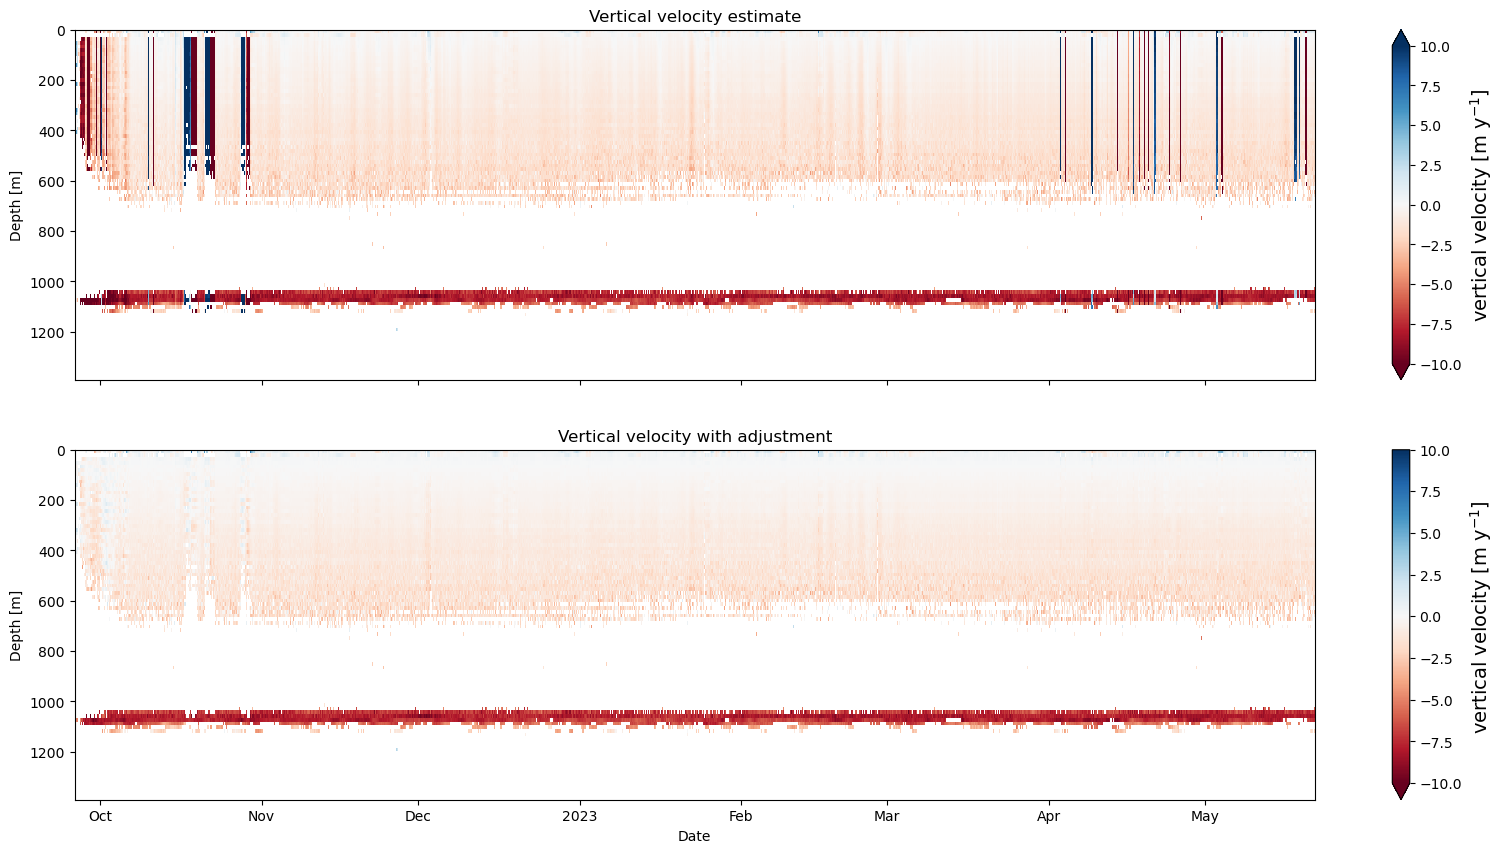

In [30]:
plot_vv_2d(a11_winter)

## Summer

In [31]:
time_to_interp = pd.date_range("2022-05-27 12:00", "2022-09-25 12:00", freq="15min")
interp_profiles = s22.interp(time=time_to_interp,method='linear')

In [32]:
a11_summer = strain_metrics(interp_profiles,40, 40,48,700)

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


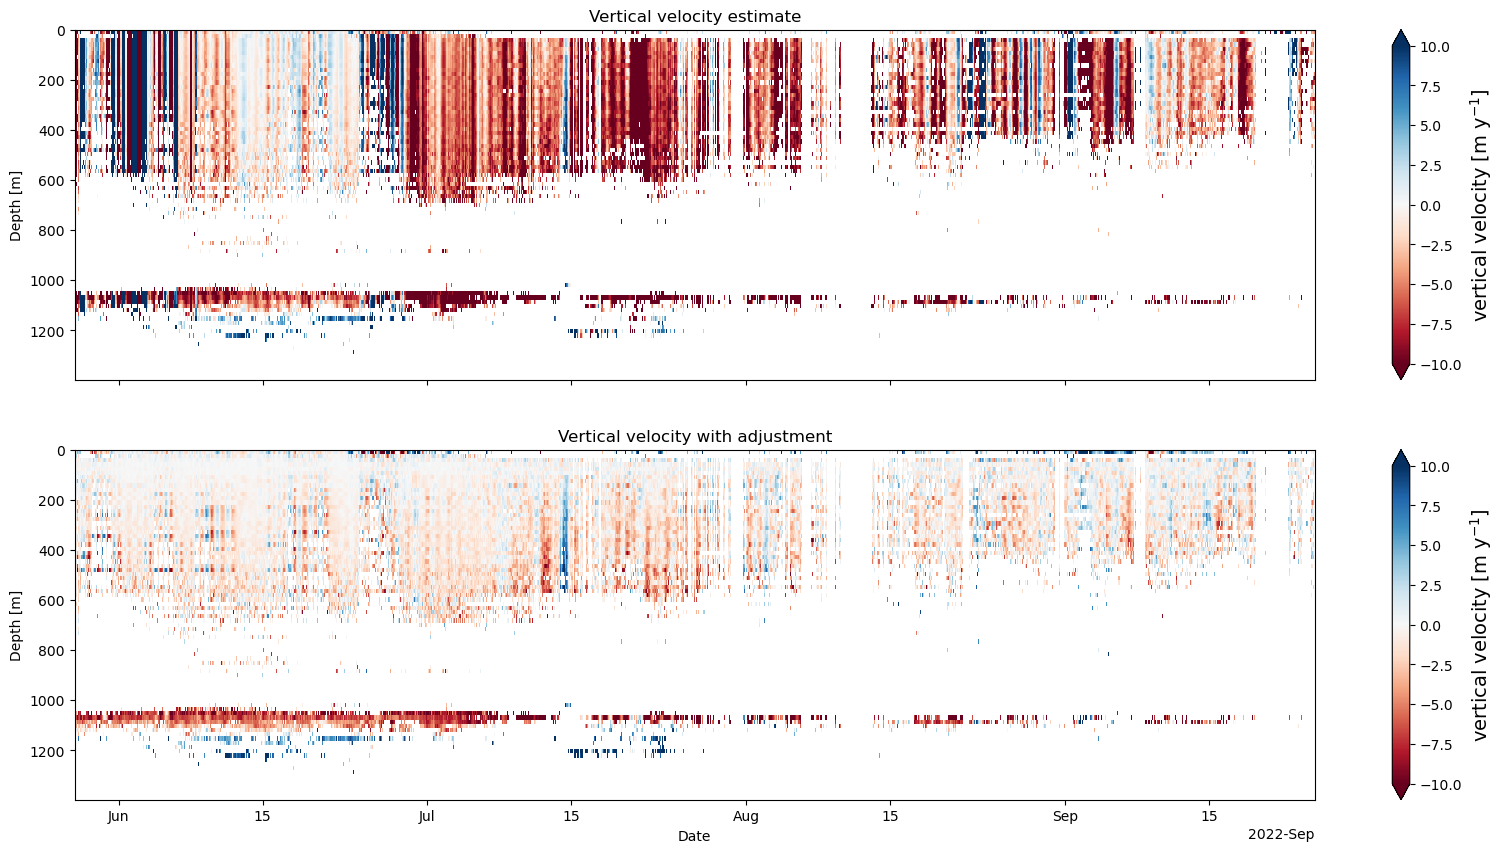

In [33]:
plot_vv_2d(a11_summer)